In [81]:
import sys
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset, WeakDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    plot_losses,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

class Wasserstein():
    
    def __init__(self, eps, device=torch.device("cpu")):
        self.eps = eps
        self.device = device
        
    def forward(self, a, b, C, n_iter=100):
        K = torch.exp(-C/self.eps)
        v = torch.ones(b.shape[0], device=self.device)
        for _ in range(n_iter):
            u = a / (K@v)
            v = b / (K.T@u)
            
        return ((torch.diag(u)@K)@torch.diag(v))
        
    def __call__(self, a, b, C, n_iter=100):
        return self.forward(a, b, C, n_iter)

In [82]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 1000,
    "batch_size": 200,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2,
    "iter_d":1,
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':25,
    'n_samples_weak':975,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_weak']\
                +cfg_dataset['n_samples_test'],
    'n_features':20,
    'n_informative':20,
    'n_targets':2,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [31]:
data = pd.read_csv("data/winequality-white.csv", sep=";")

In [83]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [84]:
X, y = data.drop("alcohol", axis=1), data["alcohol"]
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy()[:, None], test_size=0.25)

scalerX = StandardScaler()
scalerX.fit(X_train)

scalerY = StandardScaler()
scalerY.fit(y_train)

X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalerY.transform(y_train)
y_test = scalerY.transform(y_test)

X_train, X_weak, y_train, y_weak = train_test_split(X_train, y_train, test_size=0.6)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
y_train_torch = torch.Tensor(y_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

In [85]:
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=cfg["batch_size"], device=cfg["device"])

In [86]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])
optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()

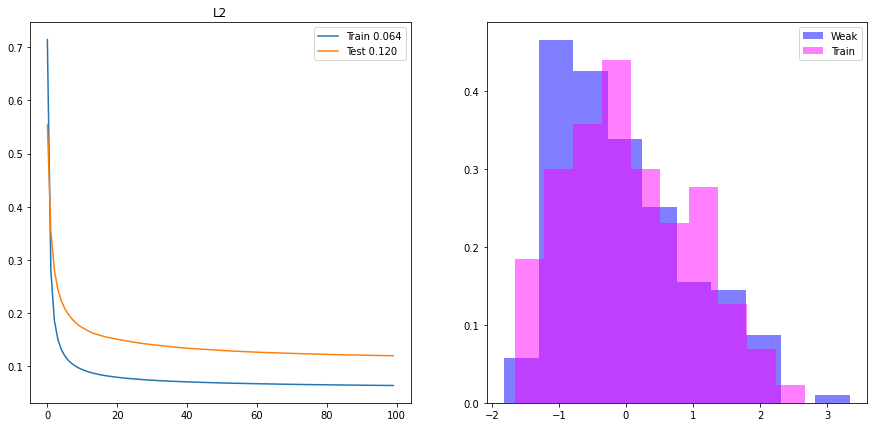

In [87]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())


    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()
        y_weak = netR(weak_loader.sample())
        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5), density=True)
        ax2.legend()
        plt.show()

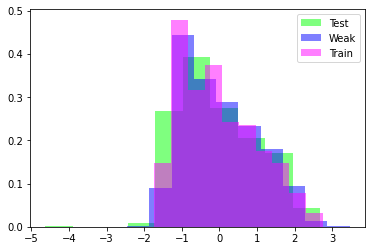

In [88]:
plt.hist(netR(X_test_torch).cpu().detach().numpy(), label='Test', fc=(0, 1, 0, 0.5), density=True)
plt.hist(netR(X_weak_torch).cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
plt.hist(y_train, label='Train',  fc=(1, 0, 1, 0.5), density=True)
plt.legend()
plt.show()

In [89]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

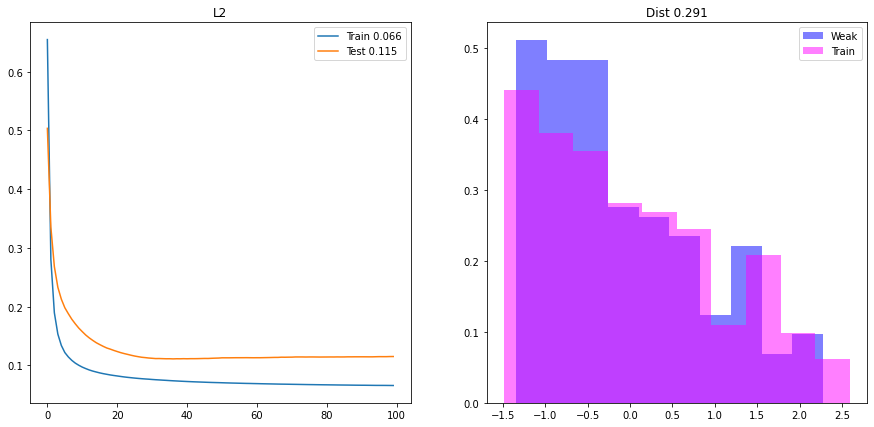

In [90]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_batch, y_weak, p=2)
        C_X = (torch.cdist(X_batch, X_batch_weak, p=2) + C)/2
        with torch.no_grad():
            a = torch.ones(y_batch.shape[0], device=cfg["device"])/y_batch.shape[0]
            b = torch.ones(y_weak.shape[0], device=cfg["device"])/y_weak.shape[0]
            P = W(a, b, C_X/C_X.max(), 100)
            
        y_pred = netR(X_batch)
        
        L2_loss = L2(y_pred, y_batch)
        W_loss = (P*C).sum()
        loss = W_loss + L2_loss
        
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5), density=True)
        ax2.legend()
        plt.show()

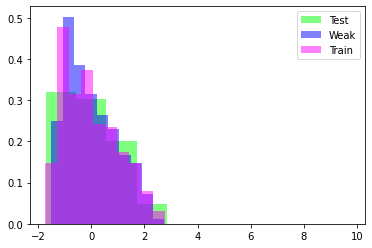

In [91]:
plt.hist(netR(X_test_torch).cpu().detach().numpy(), label='Test', fc=(0, 1, 0, 0.5), density=True)
plt.hist(netR(X_weak_torch).cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
plt.hist(y_train, label='Train',  fc=(1, 0, 1, 0.5), density=True)
plt.legend()
plt.show()

In [119]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

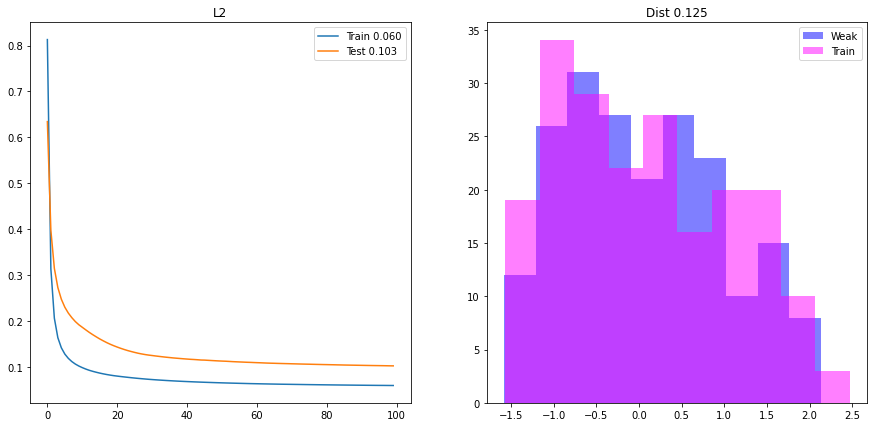

In [120]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_batch, y_weak, p=2)
        C_X = (torch.cdist(X_batch, X_batch_weak, p=2) + C)/2
        with torch.no_grad():
            a = torch.ones(y_batch.shape[0], device=cfg["device"])/y_batch.shape[0]
            b = torch.ones(y_weak.shape[0], device=cfg["device"])/y_weak.shape[0]
            P = W(a, b, C_X/C_X.max(), 20)
            
        y_pred = netR(X_batch)
        
        L2_loss = L2(y_pred, y_batch)
        W_loss = 0.1*(P*C_X).sum()
        loss = W_loss + L2_loss
        
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

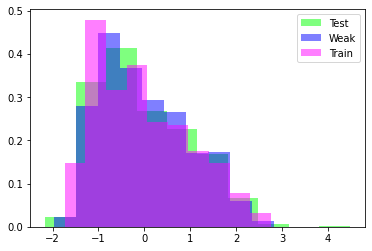

In [121]:
plt.hist(netR(X_test_torch).cpu().detach().numpy(), label='Test', fc=(0, 1, 0, 0.5), density=True)
plt.hist(netR(X_weak_torch).cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
plt.hist(y_train, label='Train',  fc=(1, 0, 1, 0.5), density=True)
plt.legend()
plt.show()

In [116]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

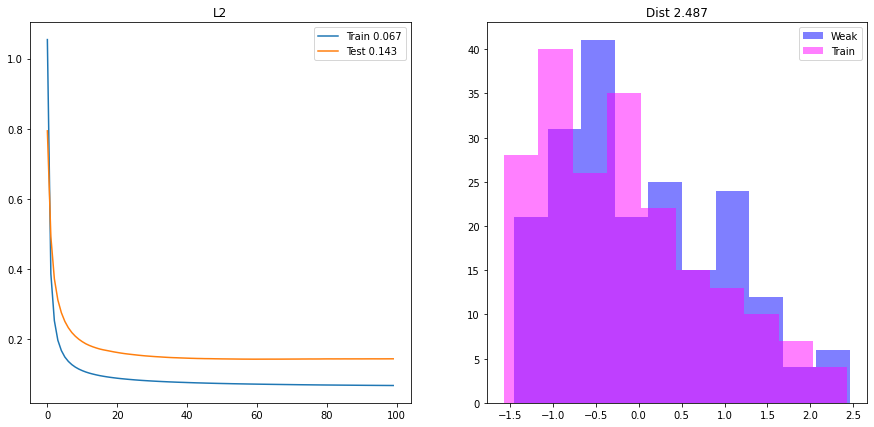

In [117]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        
        y_pred = netR(X_batch)
        y_weak = netR(X_batch_weak)
        
        joint_batch = torch.cat((X_batch, y_batch), axis=1)
        joint_weak = torch.cat((X_batch_weak, y_weak), axis=1)
        C_X = torch.cdist(joint_batch, joint_weak, p=2)
        
        with torch.no_grad():
            a = torch.ones(joint_batch.shape[0], device=cfg["device"])/joint_batch.shape[0]
            b = torch.ones(joint_weak.shape[0], device=cfg["device"])/joint_weak.shape[0]
            P = W(a, b, C_X/C_X.max(), 20)
            
        L2_loss = L2(y_pred, y_batch)
        W_loss = (P*C_X).sum()
        loss = W_loss + L2_loss
        
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

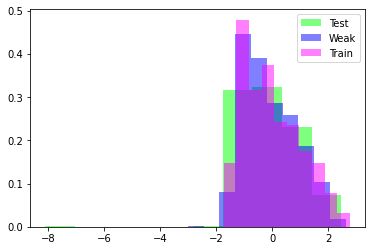

In [118]:
plt.hist(netR(X_test_torch).cpu().detach().numpy(), label='Test', fc=(0, 1, 0, 0.5), density=True)
plt.hist(netR(X_weak_torch).cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
plt.hist(y_train, label='Train',  fc=(1, 0, 1, 0.5), density=True)
plt.legend()
plt.show()